<a target="_blank" href="https://colab.research.google.com/github/taobrienlbl/advanced_earth_science_data_analysis/blob/spring_2023_iub/lessons/12_spectral_analysis_continued/12_workalong_01_filter_SOLUTION.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Simple filtering

This notebook demonstrates using the FFT to filter timeseries data.  It also demonstrates a higher-quality approach using a [Butterworth fitler](https://en.wikipedia.org/wiki/Butterworth_filter).

In [1]:
""" Import libraries. """
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

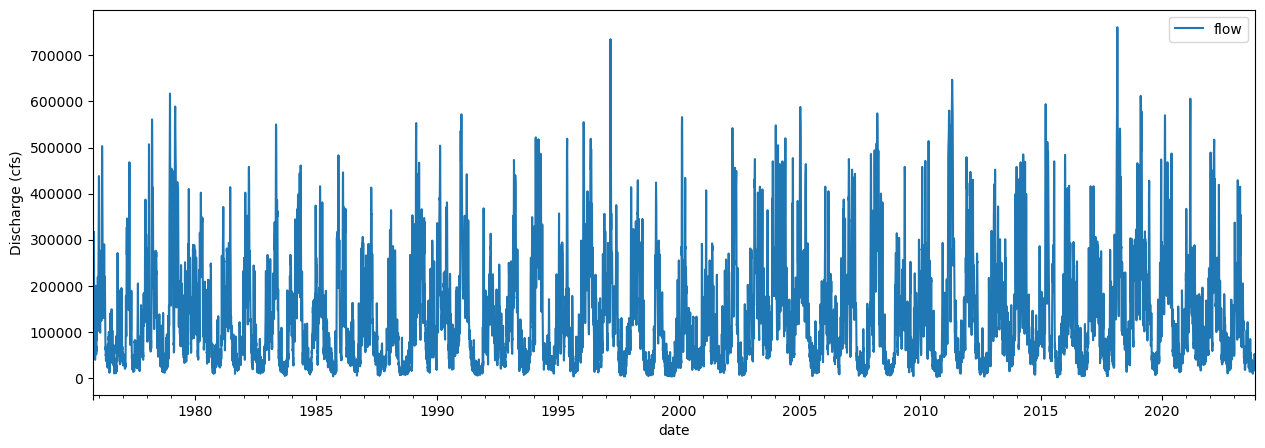

In [2]:
""" Load the data file. """
skiprows = 30

streamflow_url = "https://raw.githubusercontent.com/taobrienlbl/advanced_earth_science_data_analysis/spring_2023_iub/lessons/11_spectral_analysis_intro/cannelton_flow.dat"

# load the data
data = pd.read_csv(
    streamflow_url,
    skiprows = skiprows,
    delim_whitespace = True,
    names = ['org', 'id', 'date', 'flow', 'flag'],
    parse_dates=['date'],
    )

fig, ax = plt.subplots()
data.plot(ax = ax, x='date', y='flow', figsize=(15,5))
ax.set_ylabel('Discharge (cfs)')
plt.show()

/var/folders/0s/yp78v9d15qd8pmgtc3xknpfh37trx3/T/ipykernel_3401/1622931468.py:13: RuntimeWarning: divide by zero encountered in divide
  periods = 1/freq


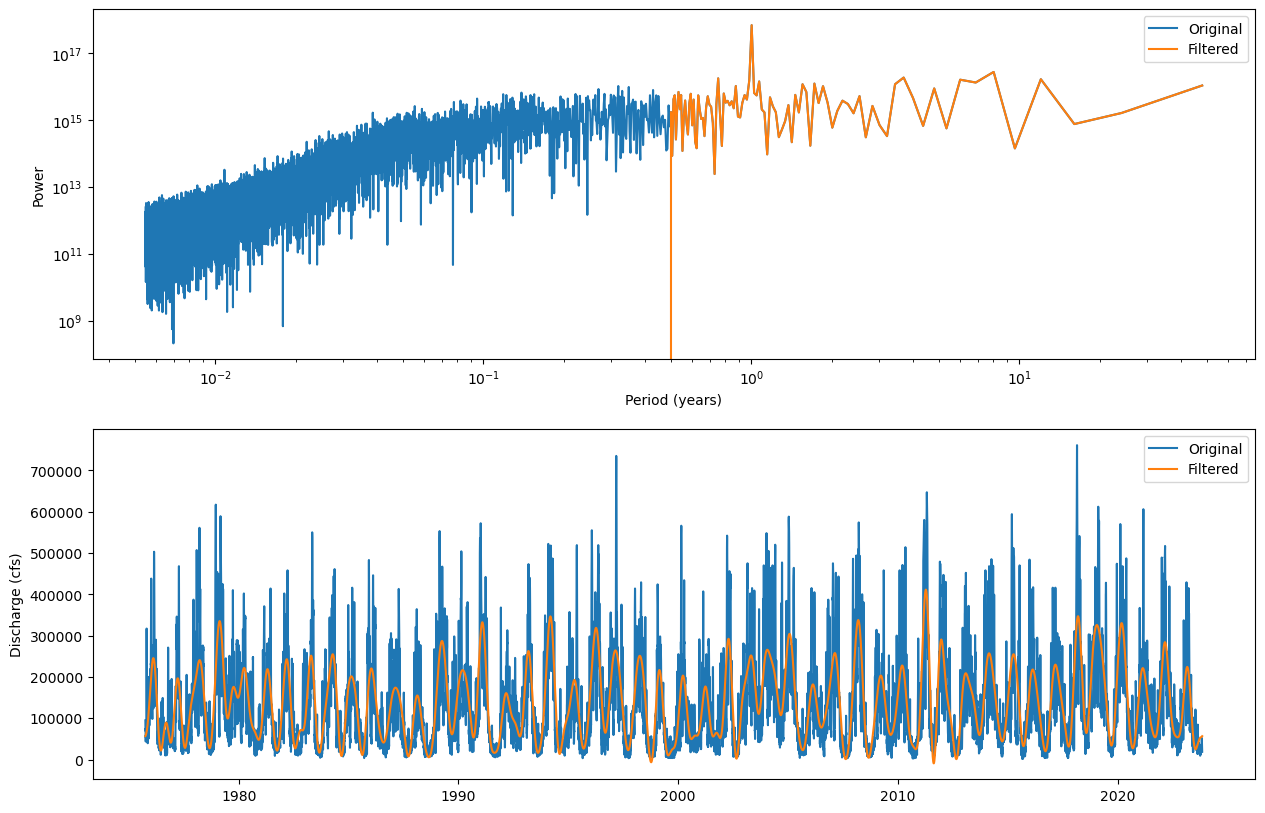

In [3]:
""" Filter the data using a naive cutoff filter. """
# calculate the fft
flow_fft = np.fft.rfft(data['flow'])

# convert the times to seconds
time_seconds = (data['date'] - data['date'][0]).dt.total_seconds()
dt = time_seconds[1] - time_seconds[0]

# calculate the frequencies
freq = np.fft.rfftfreq(len(data['flow']), dt)

# apply a simple filter; zero out data with periods less than half a year
periods = 1/freq
# convert to years
periods = periods / (60*60*24*365.25)

# find frequencies with periods less than 0.5 years
ifilter = periods < 0.5 # years

# apply the filter
filtered_flow_fft = flow_fft.copy()
filtered_flow_fft[ifilter] = 0

# convert back to the time domain
filtered_flow = np.fft.irfft(filtered_flow_fft)

# plot the power spectrum for the original and filtered data
fig, axs = plt.subplots(2,1, figsize=(15,10))

# the power spectrum
ax = axs[0]
ax.plot(periods, np.abs(flow_fft)**2, label='Original')
ax.plot(periods, np.abs(filtered_flow_fft)**2, label='Filtered')
ax.set_xlabel('Period (years)')
ax.set_ylabel('Power')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()

# the time series
ax = axs[1]
ax.plot(data['date'], data['flow'], label='Original')
ax.plot(data['date'], filtered_flow, label='Filtered')
ax.set_ylabel('Discharge (cfs)')
ax.legend()


plt.show()


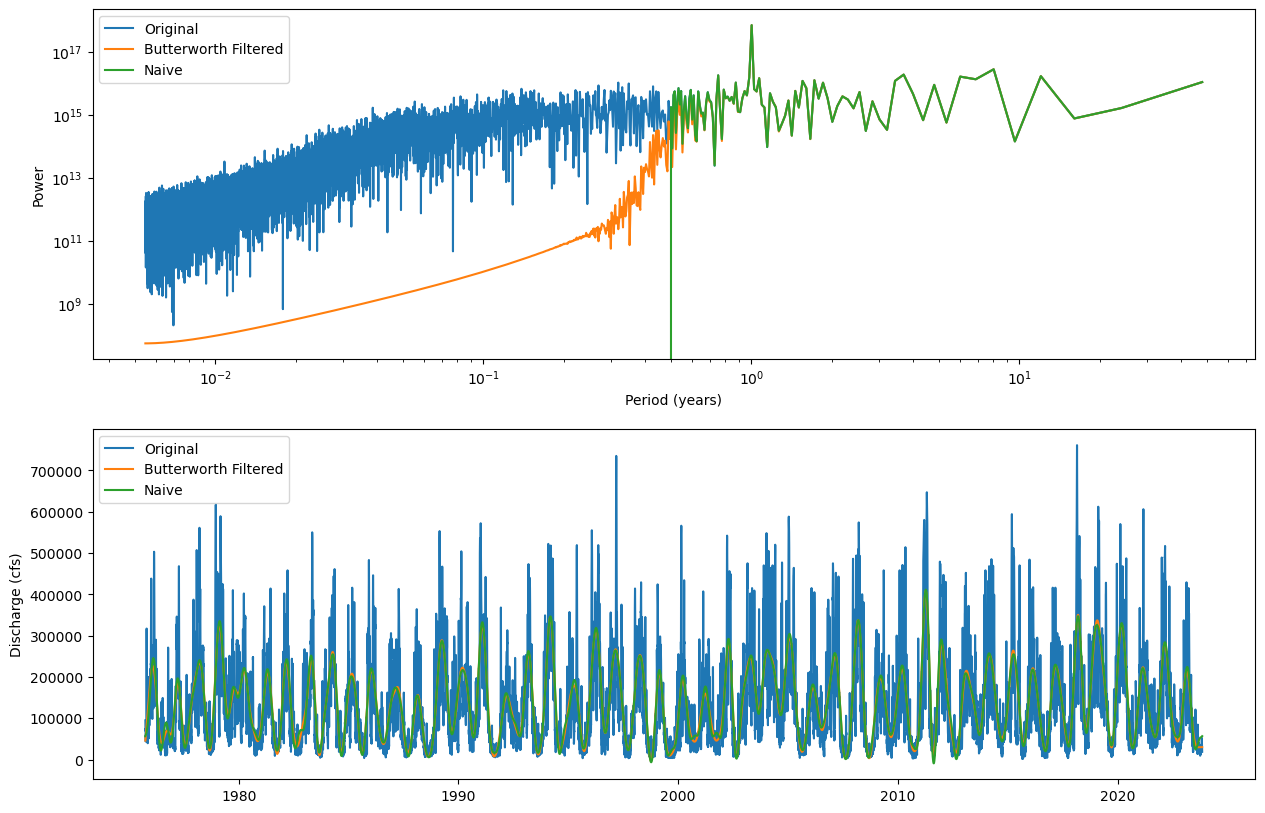

In [4]:
""" Filter the data using a Butterworth filter. """

from scipy.signal import butter, filtfilt

# set the cutoff period
cutoff_period = 0.5 # years

# convert the cutoff period to a cutoff frequency (in Hz)
cutoff_freq = 1 / cutoff_period
cutoff_freq = cutoff_freq / (60*60*24*365.25)

# normalize the cutoff frequency by the Nyquist frequency
nyquist_freq = 1/(2*dt)
cutoff_freq_norm = cutoff_freq / nyquist_freq

# set the filter order
filter_order = 5

# apply a 5th order butterworth lowpass filter, allowing periods up to 0.5 years
# note that the cutoff frequency is normalized by the Nyquist frequency
# the Nyquist frequency is 1/(2*dt)
b, a = butter(filter_order, cutoff_freq_norm, btype='lowpass')

# apply the filter
filtered_flow_butter = filtfilt(b, a, data['flow'])

# calculate the fft
filtered_flow_butter_fft = np.fft.rfft(filtered_flow_butter)

# plot the power spectrum for the original and filtered data
fig, axs = plt.subplots(2,1, figsize=(15,10))

# the power spectrum
ax = axs[0]
ax.plot(periods, np.abs(flow_fft)**2, label='Original')
ax.plot(periods, np.abs(filtered_flow_butter_fft)**2, label='Butterworth Filtered')
ax.plot(periods, np.abs(filtered_flow_fft)**2, label='Naive')
ax.set_xlabel('Period (years)')
ax.set_ylabel('Power')

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()

# the time series
ax = axs[1]
ax.plot(data['date'], data['flow'], label='Original')
ax.plot(data['date'], filtered_flow_butter, label='Butterworth Filtered')
ax.plot(data['date'], filtered_flow, label='Naive')
ax.set_ylabel('Discharge (cfs)')
ax.legend()

plt.show()



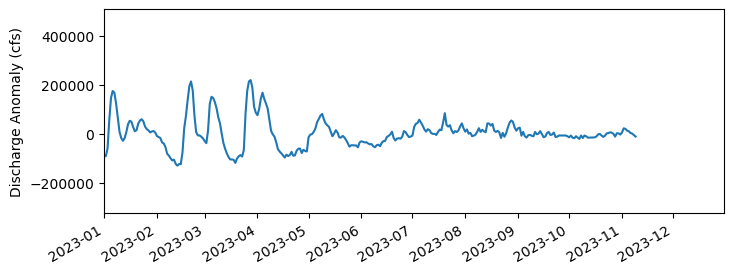

In [5]:
""" Calculate and plot the high-pass data """

flow_highpass = data['flow'] - filtered_flow_butter

fig, ax = plt.subplots(figsize = (8,3))
ax.plot(data['date'], flow_highpass)
ax.set_ylabel('Discharge Anomaly (cfs)')
# zoom in on 2023
ax.set_xlim(pd.Timestamp('2023-01-01'), pd.Timestamp('2023-12-31'))

# make the x-axis labels more readable
fig.autofmt_xdate()
plt.show()

